In [2]:
!pip install monai albumentations==1.4.24 -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.9/274.9 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 73.5 MB/s eta 0:00:00:00:01


In [3]:
import os
from pathlib import Path

import cv2
from matplotlib import pyplot as plt


train_path = "/kaggle/input/knees-x-ray-dataset/trainset"
test_path  = "/kaggle/input/knees-x-ray-dataset/testset"

In [4]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

class KneeDataset(Dataset):
    def __init__(self, root_path:str| Path, transform=None):
        root_dir = {
            f.name: f for f in Path(root_path).iterdir() if f.is_dir()
        }
        img_dir = root_dir["images"]
        mks_dir = root_dir["masks"]

        self.image_paths = [str(f) for f in sorted(Path(img_dir).rglob("*")) if f.is_file()]
        self.mask_paths  = [str(f) for f in sorted(Path(mks_dir).rglob("*")) if f.is_file()]
        self.transform   = transform

    def __len__(self):
        return len(self.image_paths)
        
    def __getitem__(self, idx:int):
        img_path = self.image_paths[idx]
        msk_path = self.mask_paths[idx]

        image = np.asarray(cv2.imread(img_path, cv2.IMREAD_UNCHANGED))
        mask  = np.asarray(cv2.imread(msk_path, cv2.IMREAD_UNCHANGED))
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask  = augmented["mask"]
        return image, mask

/usr/local/lib/python3.12/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.24). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [5]:
train_transform = A.Compose([
            # Resize theo cạnh dài, giữ tỉ lệ
            A.LongestMaxSize(max_size = 512),
            
            # Pad cho đủ vuông (image_size x image_size), pad = 0
            A.PadIfNeeded(min_height = 512,
                          min_width = 512,
                          border_mode = 0,
                          fill = 0,
                          fill_mask = 0),
            # --- GEOMETRIC AUGMENTATION ---
            A.HorizontalFlip(p = 0.5),
            A.VerticalFlip(p = 0.5),
            A.Affine(scale = (0.85, 1.15),
                     translate_percent = {"x": (-0.1, 0.1 ), "y": (-0.1, 0.1)},
                     rotate = (-15, 15),
                     fill = 0,
                     fill_mask  = 0,
                     p = 0.3),
            A.ToFloat(),
            
            # --- INTENSITY / NOISE AUGMENTATION (chỉ tác động image, không đổi mask) ---
            A.RandomBrightnessContrast(brightness_limit = (-0.2, 0.2),
                                       contrast_limit = (-0.2, 0.2),
                                       p = 0.2),
            A.RandomGamma(gamma_limit = (80, 120), p = 0.2),
            A.GaussNoise(std_range = (0.2, 0.44), mean_range = (0, 0), p = 0.2),
            A.ElasticTransform(alpha = 1, sigma = 50, p = 0.5),
            A.CoarseDropout(num_holes_range=(1, 8),
                            hole_height_range = (16, 52),   # ~3%..10% của 512,
                            hole_width_range  = (16, 52),   # ~3%..10% của 512,
                            fill = 0, 
                            fill_mask = 0,
                            p = 0.5),
            
            # --- NORMALIZE & TO TENSOR ---
            A.Normalize(normalization="min_max"),
            ToTensorV2()])

test_transform = A.Compose([
            A.LongestMaxSize(max_size = 512),
            A.PadIfNeeded(min_height= 512,
                          min_width= 512,
                          fill = 0,
                          fill_mask= 0),
            A.Normalize(normalization="min_max"),
            ToTensorV2()])

In [6]:
train_set = KneeDataset(train_path, train_transform)
test_set  = KneeDataset(test_path, test_transform)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_set, batch_size=32,shuffle=False, num_workers=2)

type : <class 'torch.Tensor'>
max  : 1.0
min  : 0.0
shape: (1, 512, 512)


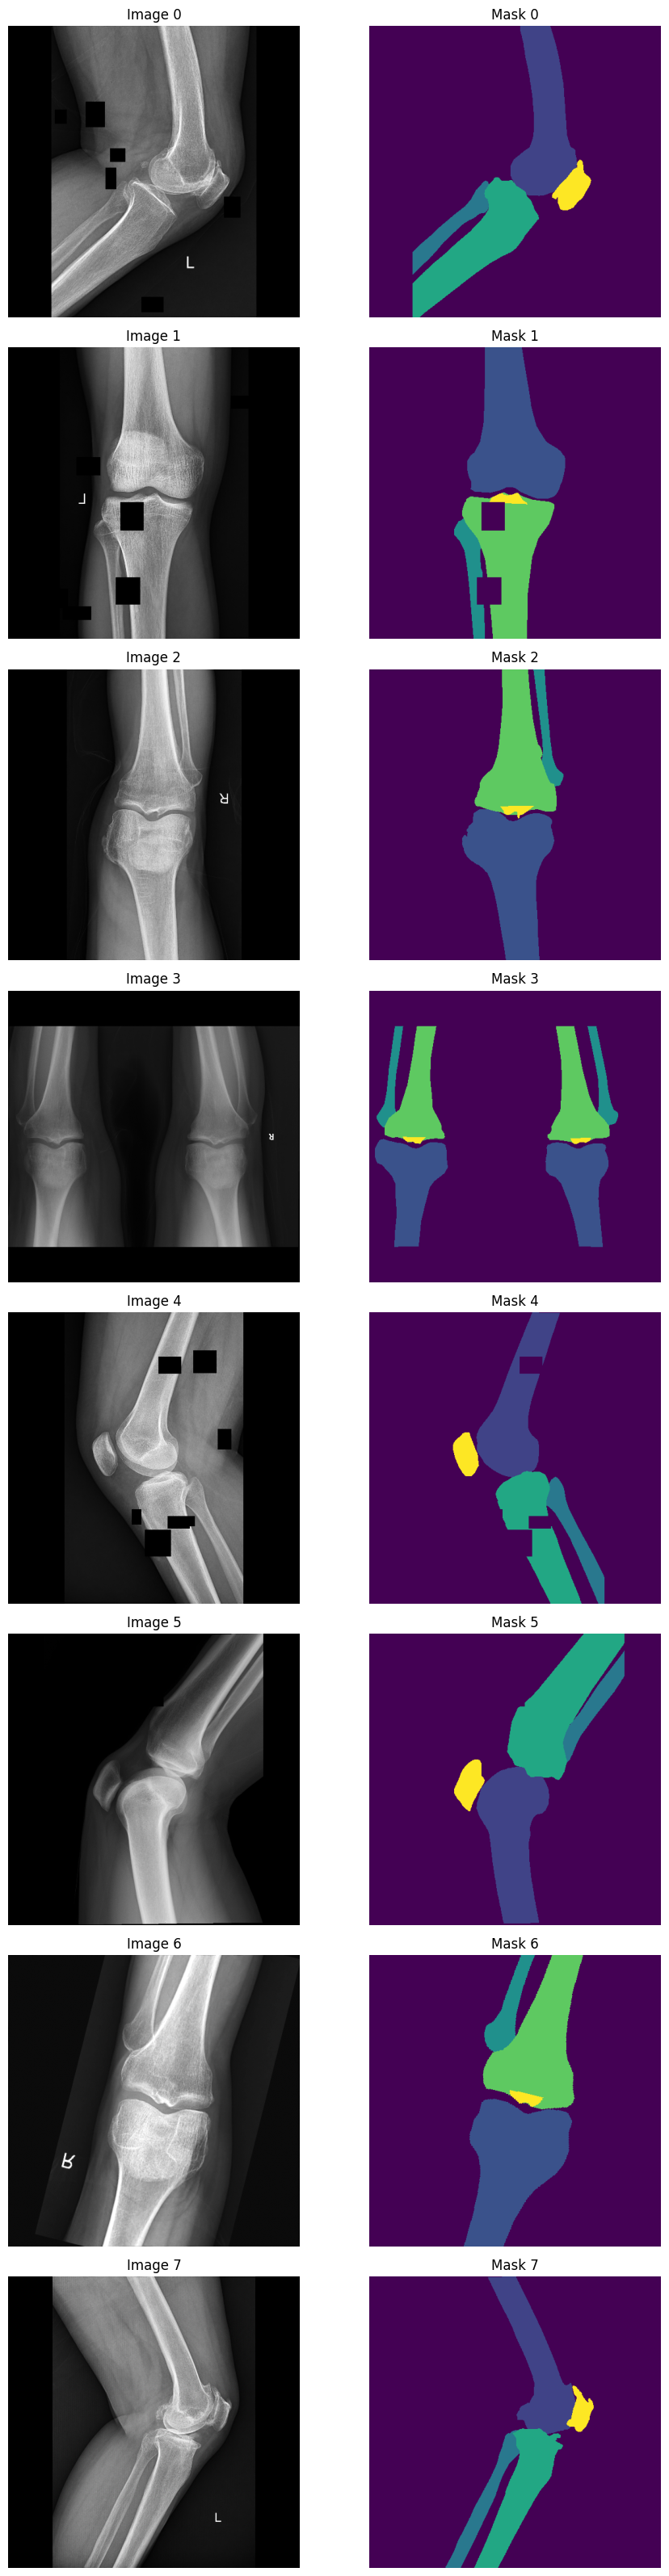

In [7]:
import matplotlib.pyplot as plt

images, masks = next(iter(train_loader))  # images: (B,C,H,W), masks: (B,...) tùy bài

# ---- Debug 1 sample (index=1) ----
x = images[1]
print("type :", type(x))
print("max  :", float(x.max()))
print("min  :", float(x.min()))
print("shape:", tuple(x.shape))  # (C,H,W)

# ---- Plot 8 samples: (image, mask) per row ----
n = 8
plt.figure(figsize=(10, 4*n))

for i in range(n):
    # ===== image =====
    img = images[i].detach().cpu()  # (C,H,W)
    if img.ndim == 3 and img.shape[0] == 1:
        img = img[0]               # (H,W)
        cmap_img = "gray"
    else:
        img = img.permute(1, 2, 0) # (H,W,C)
        cmap_img = None

    plt.subplot(n, 2, 2*i + 1)
    plt.imshow(img, cmap=cmap_img)
    plt.title(f"Image {i}")
    plt.axis("off")

    # ===== mask =====
    msk = masks[i].detach().cpu()
    # mask có thể là (H,W) hoặc (1,H,W) hoặc (H,W,1)
    if msk.ndim == 3 and msk.shape[0] == 1:
        msk = msk[0]
    if msk.ndim == 3 and msk.shape[-1] == 1:
        msk = msk[..., 0]

    plt.subplot(n, 2, 2*i + 2)
    plt.imshow(msk)
    plt.title(f"Mask {i}")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [8]:
from monai.networks.nets.unet import UNet
from monai.networks.layers import Norm
from monai.metrics.meandice import DiceMetric
from monai.metrics.meaniou import MeanIoU
from monai.losses.dice import DiceCELoss

from torch import nn
from torch.optim.adamw import AdamW

/usr/local/lib/python3.12/dist-packages/sqlalchemy/orm/query.py:195: SyntaxWarning: "is not" with 'tuple' literal. Did you mean "!="?
  if entities is not ():
2026-01-08 23:06:23.335894: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767913583.557100      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767913583.618143      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767913584.263011      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767913584.263057      55 computation_placer.cc:177] computation placer already registered.

In [9]:
model = UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=6,
    channels=(32, 64, 128, 256, 512),
    strides=(2, 2, 2, 2),
    kernel_size=3,        # hoặc (3, 3)
    up_kernel_size=3,
    num_res_units=2,
    norm=Norm.INSTANCE,   # hay dùng cho medical
)

criterion = DiceCELoss(
        include_background=True,
        to_onehot_y=True,
        softmax=True,        # cho multi-class với softmax
        lambda_dice=1.0,
        lambda_ce=1.0,
        jaccard = True,
    )

optimizer = AdamW(
    model.parameters(),
    lr=1e-4,
    weight_decay=1e-5,
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="max",
    factor=0.5,
    patience=10,
    threshold=1e-4,
    cooldown=0,
    min_lr=2e-6,
)

dice_metric = DiceMetric(include_background=False, reduction="mean", num_classes=6)
iou_metric  = MeanIoU(include_background=False, reduction="mean")

In [10]:
from typing import Tuple, Dict, Any, List

import torch
import torch.nn.functional as F
from torch.amp import autocast, GradScaler
from tabulate import tabulate
from tqdm import tqdm


# -------------------------
# Utils
# -------------------------
def to_onehot(labels: torch.Tensor, num_classes: int) -> torch.Tensor:
    """
    Chuyển labels sang one-hot.
    Input: (N, H, W) hoặc (N, 1, H, W)
    Output: (N, C, H, W)
    """
    if labels.dim() == 4:
        labels = labels.squeeze(1)  # (N, H, W)
    labels = labels.long()

    # check range (tùy chọn)
    minv = int(labels.min().item())
    maxv = int(labels.max().item())
    if minv < 0 or maxv >= num_classes:
        raise ValueError(f"Labels out of range: min={minv}, max={maxv}, num_classes={num_classes}")

    one_hot = F.one_hot(labels, num_classes=num_classes)   # (N, H, W, C)
    one_hot = one_hot.permute(0, 3, 1, 2).float()          # (N, C, H, W)
    return one_hot


def _ensure_mask_shape(masks: torch.Tensor) -> torch.Tensor:
    """
    MONAI DiceCELoss(to_onehot_y=True) thường nhận target dạng (B,1,H,W) hoặc (B,H,W).
    Chuẩn hoá về (B,1,H,W).
    """
    if masks.dim() == 3:          # (B,H,W)
        masks = masks.unsqueeze(1)
    elif masks.dim() == 4:        # (B,1,H,W) hoặc (B,C,H,W)
        pass
    else:
        raise ValueError(f"Unexpected masks dim={masks.dim()}, shape={tuple(masks.shape)}")
    return masks


def _metric_scalar(aggregate_out) -> float:
    """
    MONAI metric.aggregate() đôi khi trả tensor scalar hoặc list/tuple.
    """
    val = aggregate_out
    if isinstance(val, (list, tuple)):
        val = val[0]
    if torch.is_tensor(val):
        if val.numel() == 1:
            return float(val.item())
        return float(val.mean().item())
    return float(val)


def _get_lr(optimizer: torch.optim.Optimizer) -> float:
    return float(optimizer.param_groups[0]["lr"])


# -------------------------
# Train / Val 1 epoch
# -------------------------
def train_one_epoch(
    model: torch.nn.Module,
    loader,
    optimizer: torch.optim.Optimizer,
    criterion,
    num_classes: int,
    dice_metric,
    iou_metric,
    epoch: int,
    num_epochs: int,
    device: torch.device,
    use_amp: bool = True,
    scaler: GradScaler | None = None,
) -> Tuple[float, float, float]:

    device_type = device.type  # 'cuda' hoặc 'cpu'
    amp_enabled = bool(use_amp and device_type == "cuda")

    model.train()
    running_loss = 0.0

    dice_metric.reset()
    iou_metric.reset()

    # Nếu bạn không truyền scaler từ fit() thì tạo ở đây
    if scaler is None and amp_enabled:
        scaler = GradScaler(device_type, enabled=True)

    progress_bar = tqdm(loader, desc=f"Epoch[{epoch}/{num_epochs}] - Train", leave=False)

    for images, masks in progress_bar:
        images = images.to(device, non_blocking=True).float()
        masks  = masks.to(device, non_blocking=True).long()
        masks  = _ensure_mask_shape(masks)  # (B,1,H,W)

        optimizer.zero_grad(set_to_none=True)

        # ----- forward + loss -----
        with autocast(device_type=device_type, enabled=amp_enabled):
            logits = model(images)          # (B,C,H,W)
            loss = criterion(logits, masks) # DiceCELoss

        # ----- backward + step -----
        if amp_enabled:
            # scaler chắc chắn đã có
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        running_loss += float(loss.item())

        # ----- metrics -----
        with torch.no_grad():
            pred_labels = torch.argmax(logits, dim=1)            # (B,H,W)
            pred_onehot = to_onehot(pred_labels, num_classes)    # (B,C,H,W)

            gt_labels   = masks.squeeze(1)                       # (B,H,W)
            mask_onehot = to_onehot(gt_labels, num_classes)      # (B,C,H,W)

            dice_metric(pred_onehot, mask_onehot)
            iou_metric(pred_onehot, mask_onehot)

        progress_bar.set_postfix(loss=f"{loss.item():.4f}", lr=f"{_get_lr(optimizer):.2e}")

    n_batches = max(len(loader), 1)
    avg_loss = running_loss / n_batches

    train_dice = _metric_scalar(dice_metric.aggregate())
    train_iou  = _metric_scalar(iou_metric.aggregate())
    return avg_loss, train_dice, train_iou


def test_one_epoch(
    model: torch.nn.Module,
    loader,
    criterion,
    num_classes: int,
    dice_metric,
    iou_metric,
    epoch: int,
    num_epochs: int,
    device: torch.device,
    use_amp: bool = True,
) -> Tuple[float, float, float]:

    device_type = device.type
    amp_enabled = bool(use_amp and device_type == "cuda")

    model.eval()
    dice_metric.reset()
    iou_metric.reset()
    running_loss = 0.0

    progress_bar = tqdm(loader, desc=f"Epoch[{epoch}/{num_epochs}] - Val", leave=False)

    with torch.no_grad():
        for images, masks in progress_bar:
            images = images.to(device, non_blocking=True).float()
            masks  = masks.to(device, non_blocking=True).long()
            masks  = _ensure_mask_shape(masks)

            with autocast(device_type=device_type, enabled=amp_enabled):
                logits = model(images)
                loss = criterion(logits, masks)

            running_loss += float(loss.item())

            pred_labels = torch.argmax(logits, dim=1)
            pred_onehot = to_onehot(pred_labels, num_classes)

            gt_labels   = masks.squeeze(1)
            mask_onehot = to_onehot(gt_labels, num_classes)

            dice_metric(pred_onehot, mask_onehot)
            iou_metric(pred_onehot, mask_onehot)

            progress_bar.set_postfix(loss=f"{loss.item():.4f}")

    n_batches = max(len(loader), 1)
    avg_loss = running_loss / n_batches

    val_dice = _metric_scalar(dice_metric.aggregate())
    val_iou  = _metric_scalar(iou_metric.aggregate())
    return avg_loss, val_dice, val_iou


# -------------------------
# Full training loop (tqdm + tabulate per epoch)
# -------------------------
def fit(
    model: torch.nn.Module,
    train_loader,
    val_loader,
    optimizer: torch.optim.Optimizer,
    criterion,
    scheduler,  # ReduceLROnPlateau(mode="max") -> step(val_dice)
    dice_metric,
    iou_metric,
    num_classes: int,
    num_epochs: int,
    device: torch.device,
    use_amp: bool = True,
    save_path: str = "best_model.pt",
) -> Dict[str, Any]:

    model = model.to(device)

    device_type = device.type
    amp_enabled = bool(use_amp and device_type == "cuda")
    scaler = GradScaler(device_type, enabled=amp_enabled)  # ✅ chuẩn torch.amp

    best_val_dice = -1e9
    history: List[Dict[str, float]] = []

    headers = [
        "epoch", "lr",
        "train_loss", "train_dice", "train_iou",
        "val_loss", "val_dice", "val_iou",
        "best"
    ]

    for epoch in range(1, num_epochs + 1):
        train_loss, train_dice, train_iou = train_one_epoch(
            model=model,
            loader=train_loader,
            optimizer=optimizer,
            criterion=criterion,
            num_classes=num_classes,
            dice_metric=dice_metric,
            iou_metric=iou_metric,
            epoch=epoch,
            num_epochs=num_epochs,
            device=device,
            use_amp=use_amp,
            scaler=scaler,  # truyền scaler (nếu amp_enabled=False thì train_one_epoch sẽ tự fallback)
        )

        val_loss, val_dice, val_iou = test_one_epoch(
            model=model,
            loader=val_loader,
            criterion=criterion,
            num_classes=num_classes,
            dice_metric=dice_metric,
            iou_metric=iou_metric,
            epoch=epoch,
            num_epochs=num_epochs,
            device=device,
            use_amp=use_amp,
        )

        # scheduler theo metric (mode="max")
        if scheduler is not None:
            scheduler.step(val_dice)

        is_best = val_dice > best_val_dice
        if is_best:
            best_val_dice = val_dice
            torch.save(
                {
                    "epoch": epoch,
                    "model_state": model.state_dict(),
                    "optimizer_state": optimizer.state_dict(),
                    "best_val_dice": best_val_dice,
                },
                save_path,
            )

        row = [
            epoch,
            f"{_get_lr(optimizer):.2e}",
            f"{train_loss:.4f}", f"{train_dice:.4f}", f"{train_iou:.4f}",
            f"{val_loss:.4f}",   f"{val_dice:.4f}",   f"{val_iou:.4f}",
            "✅" if is_best else ""
        ]
        print(tabulate([row], headers=headers, tablefmt="github"))

        history.append(
            dict(
                epoch=epoch,
                lr=_get_lr(optimizer),
                train_loss=train_loss,
                train_dice=train_dice,
                train_iou=train_iou,
                val_loss=val_loss,
                val_dice=val_dice,
                val_iou=val_iou,
            )
        )

    return {"best_val_dice": best_val_dice, "history": history, "save_path": save_path}

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device using:", device)

Device using: cuda


In [12]:

# results = fit(
#     model=model,
#     train_loader=train_loader,
#     val_loader=test_loader,
#     optimizer=optimizer,
#     criterion=criterion,
#     scheduler=scheduler,
#     dice_metric=dice_metric,
#     iou_metric=iou_metric,
#     num_classes=6,
#     num_epochs=200,
#     device=device,
#     use_amp=True,
#     save_path="best_unet_knee.pt",
# )

In [13]:
from typing import Optional, List, Dict, Any
import torch
from torch.amp import autocast
from tabulate import tabulate


def _labels_from_mask(masks: torch.Tensor) -> torch.Tensor:
    # trả về (B,H,W) label
    if masks.dim() == 3:
        return masks.long()
    if masks.dim() == 4:
        if masks.size(1) == 1:
            return masks[:, 0].long()
        return torch.argmax(masks, dim=1).long()
    raise ValueError(f"Unexpected masks shape: {tuple(masks.shape)}")


@torch.no_grad()
def evaluate_best_checkpoint_on_test(
    model: torch.nn.Module,
    checkpoint_path: str,
    test_loader,
    num_classes: int,
    device: torch.device,
    class_names: Optional[List[str]] = None,
    include_background: bool = False,
    ignore_empty: bool = True,
    eps: float = 1e-6,
    use_amp: bool = True,
    print_table: bool = True,
    debug_first_batch: bool = False,
) -> Dict[str, Any]:
    # ---- load checkpoint ----
    ckpt = torch.load(checkpoint_path, map_location="cpu")
    if isinstance(ckpt, dict) and ("model_state" in ckpt or "state_dict" in ckpt):
        state = ckpt.get("model_state", ckpt.get("state_dict"))
    else:
        state = ckpt
    model.load_state_dict(state, strict=True)

    model.to(device)
    model.eval()

    if class_names is None:
        class_names = [f"class_{i}" for i in range(num_classes)]
    if len(class_names) != num_classes:
        raise ValueError(f"class_names length={len(class_names)} != num_classes={num_classes}")

    device_type = device.type
    amp_enabled = bool(use_amp and device_type == "cuda")

    # ✅ accumulator luôn ở CPU -> không bao giờ mismatch
    sum_dice_cpu  = torch.zeros(num_classes, dtype=torch.float64)  # CPU
    cnt_dice_cpu  = torch.zeros(num_classes, dtype=torch.float64)  # CPU
    gt_pixels_cpu = torch.zeros(num_classes, dtype=torch.float64)  # CPU

    for bi, (images, masks) in enumerate(test_loader):
        images = images.to(device, non_blocking=True).float()
        masks  = masks.to(device, non_blocking=True)

        gt_labels = _labels_from_mask(masks).to(device)  # chắc chắn ở device (B,H,W)

        with autocast(device_type=device_type, enabled=amp_enabled):
            logits = model(images)

        pred_labels = torch.argmax(logits, dim=1).long().to(device)  # (B,H,W)

        # onehot bool (trên GPU)
        pred_oh = torch.nn.functional.one_hot(pred_labels, num_classes=num_classes).permute(0, 3, 1, 2).to(torch.bool)
        gt_oh   = torch.nn.functional.one_hot(gt_labels,   num_classes=num_classes).permute(0, 3, 1, 2).to(torch.bool)

        inter    = (pred_oh & gt_oh).sum(dim=(2, 3)).to(torch.float64)   # (B,C) GPU
        pred_sum = pred_oh.sum(dim=(2, 3)).to(torch.float64)            # (B,C) GPU
        gt_sum   = gt_oh.sum(dim=(2, 3)).to(torch.float64)              # (B,C) GPU

        dice = (2.0 * inter + eps) / (pred_sum + gt_sum + eps)          # (B,C) GPU

        if debug_first_batch and bi == 0:
            print("DEBUG devices:")
            print(" images:", images.device, images.dtype)
            print(" masks :", masks.device, masks.dtype)
            print(" gt_labels:", gt_labels.device, gt_labels.dtype)
            print(" logits:", logits.device, logits.dtype)
            print(" gt_sum:", gt_sum.device, gt_sum.dtype)

        # ---- move batch stats to CPU rồi mới accumulate ----
        gt_pixels_cpu += gt_sum.sum(dim=0).detach().cpu()

        if ignore_empty:
            valid = (gt_sum > 0)
            sum_dice_cpu += torch.where(valid, dice, torch.zeros_like(dice)).sum(dim=0).detach().cpu()
            cnt_dice_cpu += valid.sum(dim=0).to(torch.float64).detach().cpu()
        else:
            sum_dice_cpu += dice.sum(dim=0).detach().cpu()
            cnt_dice_cpu += torch.ones_like(dice).sum(dim=0).to(torch.float64).detach().cpu()

    dice_per_class = sum_dice_cpu / torch.clamp(cnt_dice_cpu, min=1.0)
    dice_per_class = torch.where(cnt_dice_cpu > 0, dice_per_class, torch.tensor(float("nan"), dtype=torch.float64))

    start_idx = 0 if include_background else 1
    overall_mean = float(torch.nanmean(dice_per_class[start_idx:]).item()) if num_classes > start_idx else float("nan")

    if print_table:
        rows = []
        for i in range(num_classes):
            md = dice_per_class[i].item()
            rows.append([
                i,
                class_names[i],
                "" if torch.isnan(dice_per_class[i]) else f"{md:.4f}",
                int(cnt_dice_cpu[i].item()),
                int(gt_pixels_cpu[i].item()),
            ])
        print(tabulate(rows, headers=["class_id", "class_name", "mean_dice", "support_imgs", "gt_pixels"], tablefmt="github"))
        print(f"\nOverall mean Dice ({'include_bg' if include_background else 'exclude_bg'}): {overall_mean:.4f}")

    return {
        "dice_per_class": [float(x) if not torch.isnan(torch.tensor(x)) else float("nan") for x in dice_per_class.tolist()],
        "dice_overall_mean": overall_mean,
        "support_per_class": [int(x) for x in cnt_dice_cpu.tolist()],
        "gt_pixels_per_class": [int(x) for x in gt_pixels_cpu.tolist()],
        "checkpoint_path": checkpoint_path,
    }

In [14]:
class_names = ["bg", "class1", "class2", "class3", "class4", "class5"]

res = evaluate_best_checkpoint_on_test(
    model=model,
    checkpoint_path="/kaggle/working/best_unet_knee.pt",
    test_loader=test_loader,
    num_classes=6,
    device=device,
    class_names=class_names,
    include_background=False,
    ignore_empty=True,
    use_amp=True,
    print_table=True,
)


|   class_id | class_name   |   mean_dice |   support_imgs |   gt_pixels |
|------------|--------------|-------------|----------------|-------------|
|          0 | bg           |      0.9944 |            300 |    62712890 |
|          1 | class1       |      0.9783 |            300 |     7515444 |
|          2 | class2       |      0.9391 |            300 |     1870599 |
|          3 | class3       |      0.9722 |            300 |     6156837 |
|          4 | class4       |      0.8632 |            202 |      157765 |
|          5 | class5       |      0.9181 |             98 |      229665 |

Overall mean Dice (exclude_bg): 0.9342


In [15]:
from typing import Optional, List, Tuple
import torch
import numpy as np
import matplotlib.pyplot as plt


def load_checkpoint_to_model(model: torch.nn.Module, checkpoint_path: str, device: torch.device) -> torch.nn.Module:
    """Load checkpoint (dict có model_state/state_dict hoặc state_dict thuần) vào model."""
    ckpt = torch.load(checkpoint_path, map_location="cpu")
    if isinstance(ckpt, dict) and ("model_state" in ckpt or "state_dict" in ckpt):
        state = ckpt.get("model_state", ckpt.get("state_dict"))
    else:
        state = ckpt
    model.load_state_dict(state, strict=True)
    model.to(device)
    model.eval()
    return model


def _to_label_mask(m: torch.Tensor) -> torch.Tensor:
    """
    Chuẩn hoá mask về label dạng (B,H,W).
    Hỗ trợ: (B,H,W) / (B,1,H,W) / (B,C,H,W) one-hot.
    """
    if m.dim() == 3:
        return m.long()
    if m.dim() == 4:
        if m.size(1) == 1:
            return m[:, 0].long()
        return torch.argmax(m, dim=1).long()
    raise ValueError(f"Unexpected mask shape: {tuple(m.shape)}")


def _prep_image_for_show(img: np.ndarray) -> np.ndarray:
    """
    img: (H,W) hoặc (H,W,3). Chuẩn hoá min-max về [0,1] để hiển thị.
    """
    img = img.astype(np.float32)
    vmin, vmax = float(img.min()), float(img.max())
    if vmax - vmin < 1e-8:
        return np.zeros_like(img, dtype=np.float32)
    return (img - vmin) / (vmax - vmin)


@torch.no_grad()
def visualize_predictions(
    model: torch.nn.Module,
    loader,
    device: torch.device,
    num_classes: int,
    class_names: Optional[List[str]] = None,
    checkpoint_path: Optional[str] = None,
    max_samples: int = 4,
    alpha: float = 0.45,
    use_amp: bool = True,
    seed: Optional[int] = None,
    save_path: Optional[str] = None,
) -> None:
    """
    Vẽ trực quan: Image / GT / Pred / Overlay(Pred on Image)

    Args:
      checkpoint_path: nếu truyền vào thì tự load best model trước khi visualize
      max_samples: số ảnh trong batch để hiển thị
      alpha: độ trong suốt của overlay
      save_path: nếu muốn lưu hình (png)
    """
    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)

    if checkpoint_path is not None:
        model = load_checkpoint_to_model(model, checkpoint_path, device)
    else:
        model.to(device)
        model.eval()

    if class_names is None:
        class_names = [f"class_{i}" for i in range(num_classes)]
    if len(class_names) != num_classes:
        raise ValueError(f"class_names length={len(class_names)} != num_classes={num_classes}")

    # lấy 1 batch để vẽ
    batch = next(iter(loader))
    images, masks = batch

    images = images.to(device, non_blocking=True).float()
    masks  = masks.to(device, non_blocking=True)

    device_type = device.type
    amp_enabled = bool(use_amp and device_type == "cuda")

    # forward
    with torch.amp.autocast(device_type=device_type, enabled=amp_enabled):
        logits = model(images)                 # (B,C,H,W)

    pred = torch.argmax(logits, dim=1)         # (B,H,W)
    gt   = _to_label_mask(masks)               # (B,H,W)

    # đưa về CPU để plot
    images_cpu = images.detach().cpu()
    pred_cpu   = pred.detach().cpu().numpy()
    gt_cpu     = gt.detach().cpu().numpy()

    B = images_cpu.shape[0]
    n = min(max_samples, B)

    # colormap cho mask (dùng colormap có sẵn, không hard-code màu)
    cmap = plt.get_cmap("tab20", num_classes)

    fig, axes = plt.subplots(nrows=n, ncols=4, figsize=(16, 4*n))
    if n == 1:
        axes = np.expand_dims(axes, axis=0)

    for i in range(n):
        x = images_cpu[i]  # (C,H,W)
        if x.ndim != 3:
            raise ValueError(f"Unexpected image shape (per-sample): {x.shape}")

        if x.shape[0] == 1:
            img = x[0].numpy()                     # (H,W)
            img_show = _prep_image_for_show(img)
            show_kwargs = dict(cmap="gray")
        else:
            img = x[:3].permute(1, 2, 0).numpy()   # (H,W,3)
            img_show = _prep_image_for_show(img)
            show_kwargs = dict()

        gt_i = gt_cpu[i]
        pr_i = pred_cpu[i]

        # 1) Image
        ax = axes[i, 0]
        ax.imshow(img_show, **show_kwargs)
        ax.set_title("Image")
        ax.axis("off")

        # 2) GT
        ax = axes[i, 1]
        ax.imshow(gt_i, cmap=cmap, vmin=0, vmax=num_classes-1)
        ax.set_title("GT")
        ax.axis("off")

        # 3) Pred
        ax = axes[i, 2]
        ax.imshow(pr_i, cmap=cmap, vmin=0, vmax=num_classes-1)
        ax.set_title("Pred")
        ax.axis("off")

        # 4) Overlay (Pred on Image)
        ax = axes[i, 3]
        ax.imshow(img_show, **show_kwargs)
        ax.imshow(pr_i, cmap=cmap, vmin=0, vmax=num_classes-1, alpha=alpha)
        ax.set_title("Overlay (Pred)")
        ax.axis("off")

    # legend (class id -> name)
    legend_text = "\n".join([f"{i}: {name}" for i, name in enumerate(class_names)])
    fig.suptitle("Segmentation Visualization\n" + legend_text, fontsize=12, y=0.98)
    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi=150, bbox_inches="tight")

    plt.show()


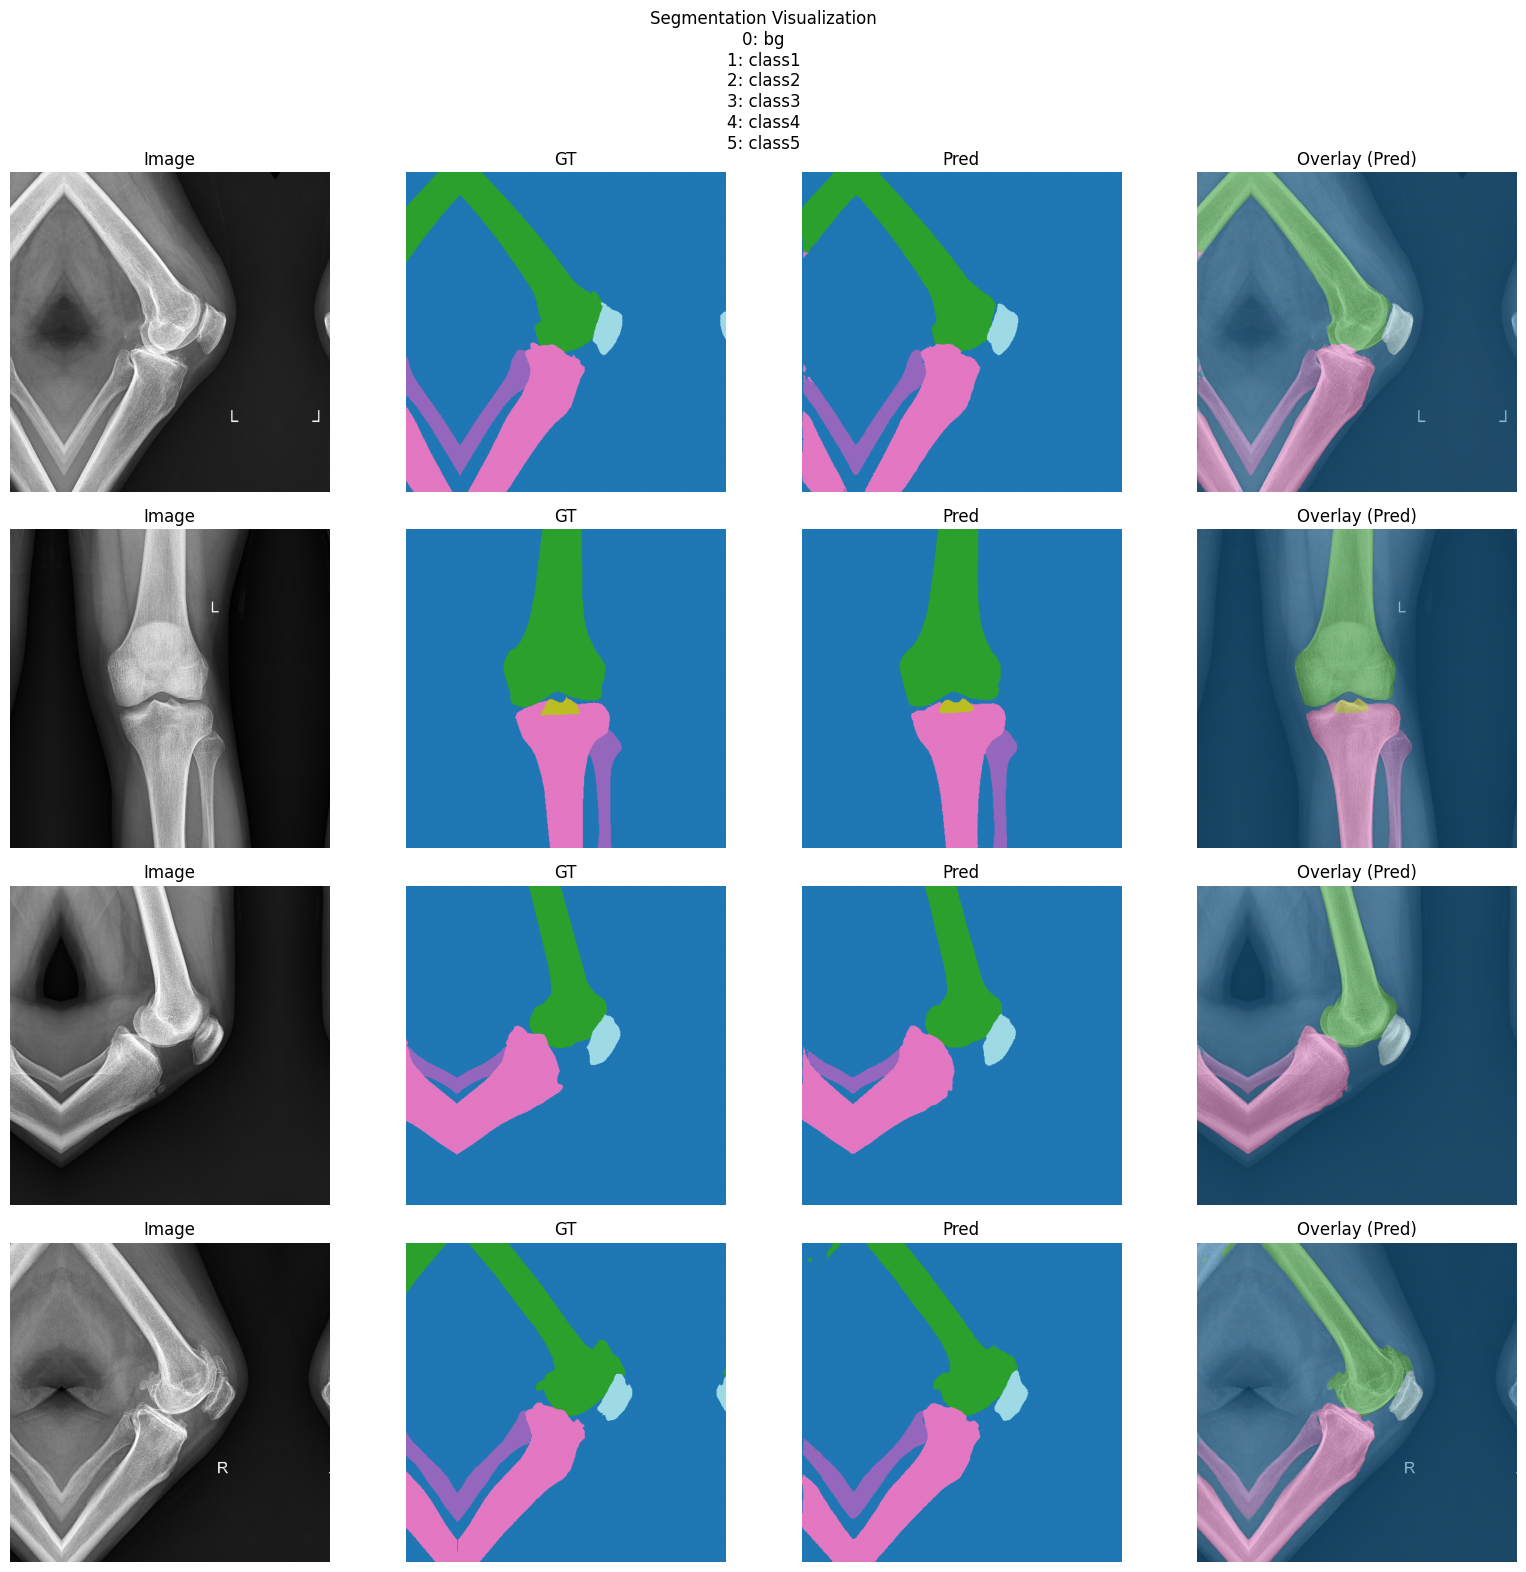

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_names = ["bg", "class1", "class2", "class3", "class4", "class5"]

visualize_predictions(
    model=model,
    loader=test_loader,                   # hoặc val_loader
    device=device,
    num_classes=6,
    class_names=class_names,
    checkpoint_path="/kaggle/working/best_unet_knee.pt",  # load best
    max_samples=4,
    alpha=0.5,
    save_path=None,             # optional
)